## Style Transfer: Histogram, Fourier Transfer, Efros & Leung Texture Synthesis and Fast Neural Network
By Siru Chen
![title](ImageTransferEx.png)


## Histogram
 A statistical method that adjusts th epixel values of a target image, so that its histogram matches the histogram of a reference imgae.
 It Adjust color and brightnes distribution.
 * Compute histograms of both target and reference images
 * Calculate CDF of both images
 * Use inverse mapping to adjust the pixel values of target to match those of the reference image.
![Title](histogram1.png)

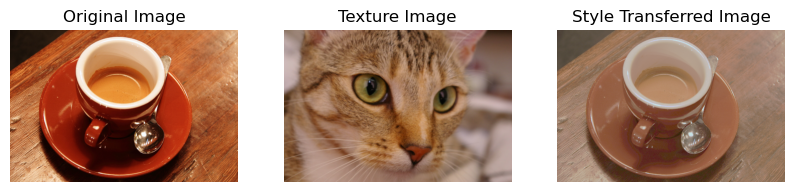

In [1]:
from skimage.transform import resize
from skimage import data, exposure, img_as_float,color
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

def load_skimage_as_pil(img_skimage):
    """Convert a skimage image to a PIL image."""
    return Image.fromarray((img_skimage * 255).astype(np.uint8))

# Load images from skimage

img_data = data.chelsea()
#img_data = img_as_float(io.imread("rice_texture2.jpg"))
image_A = img_as_float(img_data)
image_B = img_as_float(data.coffee())     # Use the coffee image as the content image

# Resize images to the same dimensions
target_size = image_B.shape[:2]  # Use the dimensions of image B
image_A_resized = resize(image_A, target_size)

# Convert skimage images to PIL for processing
pil_image_A = load_skimage_as_pil(image_A_resized)
pil_image_B = load_skimage_as_pil(image_B)

# Match histograms for color adaptation
matched_image = exposure.match_histograms(image_B, image_A_resized)

# Optionally, display using matplotlib to embed in Jupyter notebooks
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(pil_image_B)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Texture Image')
plt.imshow(pil_image_A)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Style Transferred Image')
plt.imshow(matched_image)
plt.axis('off')
plt.show()


## Fourier Transform
A mathematical method that transforms an image from spatial domain to frequency domain. By manipluating frequency domain we can extract texture.
* Perform a Fourier transfrom on grayscale image
* Design a mask to apply high-pass filtering (for texture and details)
* Perform an inverse Fourier transfform to convert masked image back to spatial domain.

## Fourier Transform
![Title](fourier1.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float, color, io, transform

def fft_texture_extraction(image, low_cutoff=5, high_cutoff=50):
    """Extract texture using FFT and high-pass filtering."""
    # Convert to grayscale
    gray_image = color.rgb2gray(image)

    # Perform FFT
    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)

    # Create a mask for high-pass filtering
    rows, cols = gray_image.shape
    crow, ccol = rows // 2 , cols // 2

    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-high_cutoff:crow+high_cutoff, ccol-high_cutoff:ccol+high_cutoff] = 1
    mask[crow-low_cutoff:crow+low_cutoff, ccol-low_cutoff:ccol+low_cutoff] = 0

    # Apply mask and inverse FFT
    fshift_masked = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_masked)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize the result to preserve black regions
    img_back = (img_back - np.min(img_back)) / (np.max(img_back) - np.min(img_back))
    img_back = 1 - img_back  # Invert to make black areas black

    return gray_image, fshift, mask, fshift_masked, img_back

def overlay_blend(background, overlay, texture_strength=0.5):
    """Applies an overlay blend mode."""
    # return np.clip(background * (1 - texture_strength) + overlay * texture_strength, 0, 1)
    return np.clip(background * (1 - texture_strength) + background * overlay * texture_strength , 0, 1)

def apply_texture_to_image(texture, target_image, texture_strength=0.5):
    """Apply the extracted texture to the target image."""
    blended_image = np.empty_like(target_image)
    for i in range(3):
        blended_image[:, :, i] = overlay_blend(target_image[:, :, i], texture, texture_strength)
    return blended_image

def plot_cutoff_regions(ax, rows, cols, crow, ccol, low_cutoff, high_cutoff):
    """Plot low and high cutoff regions on FFT image."""
    rect_low = plt.Rectangle((ccol-low_cutoff, crow-low_cutoff), 2*low_cutoff, 2*low_cutoff,
                             linewidth=1, edgecolor='r', facecolor='none')
    rect_high = plt.Rectangle((ccol-high_cutoff, crow-high_cutoff), 2*high_cutoff, 2*high_cutoff,
                              linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect_low)
    ax.add_patch(rect_high)

# Load images
target_image = img_as_float(data.coffee())
texture_image = img_as_float(io.imread('texture1.jpeg'))

# Extract texture using FFT
gray_texture, fshift, mask, fshift_masked, texture = fft_texture_extraction(texture_image)

# Resize texture to match the target image dimensions
texture_resized = transform.resize(texture, target_image.shape[:2])

# Apply the texture to the target image
textured_image = apply_texture_to_image(texture_resized, target_image,1)


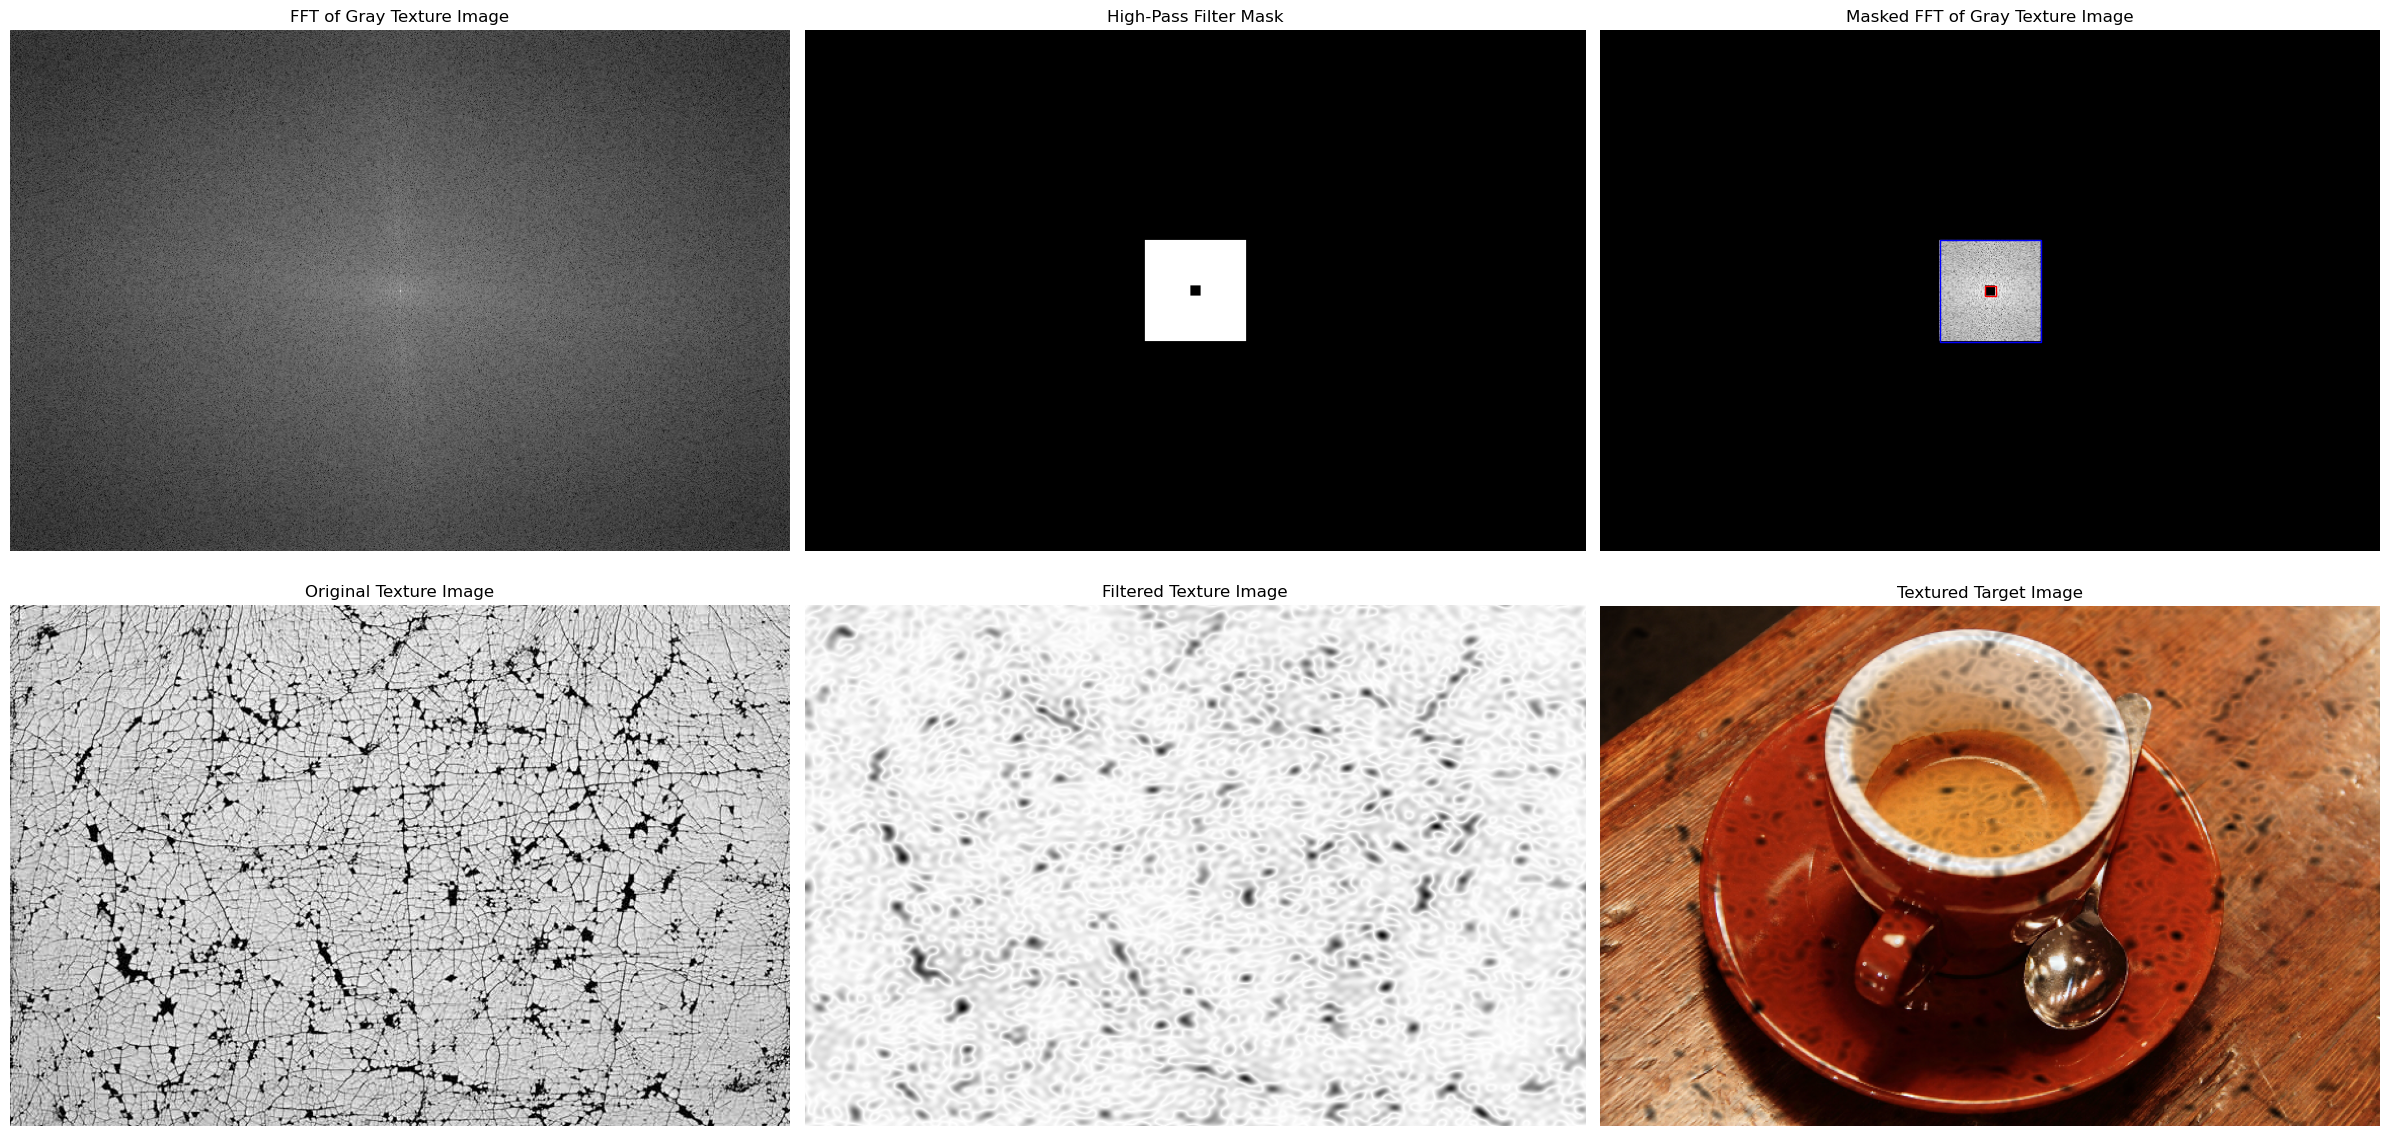

In [3]:

# Display the original and textured images
fig, ax = plt.subplots(2, 3, figsize=(24, 12))


# FFT of Gray Texture Image with Cutoff Regions
ax[0, 0].imshow(np.log1p(np.abs(fshift)), cmap='gray')
ax[0, 0].set_title('FFT of Gray Texture Image')
plot_cutoff_regions(ax[0, 2], gray_texture.shape[0], gray_texture.shape[1],
                    gray_texture.shape[0]//2, gray_texture.shape[1]//2, 5, 50)
ax[0, 0].axis('off')

# Mask for High-Pass Filtering
ax[0, 1].imshow(mask, cmap='gray')
ax[0, 1].set_title('High-Pass Filter Mask')
ax[0, 1].axis('off')

# Masked FFT of Gray Texture Image
ax[0, 2].imshow(np.log1p(np.abs(fshift_masked)), cmap='gray')
ax[0, 2].set_title('Masked FFT of Gray Texture Image')
ax[0, 2].axis('off')

# Original Texture Image
ax[1, 0].imshow(texture_image, cmap='gray')
ax[1, 0].set_title('Original Texture Image')
ax[1, 0].axis('off')

# Filtered Texture Image
ax[1, 1].imshow(texture, cmap='gray')
ax[1, 1].set_title('Filtered Texture Image')
ax[1, 1].axis('off')


# Textured Target Image
ax[1, 2].imshow(textured_image)
ax[1, 2].set_title('Textured Target Image')
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()


## Efros & Leung Algorithm
Generate new image by analyzing and coping the local block structure of a sample image. It works by matching and stitching local patches to reproduce similar texture pattern.
* Divide sample image into small patches
* Select the best matching patch from the sample image and stitch onto the target image
* Minimize stitching artifacts
* Iterate till complete

## Efros & Leung Algorithm -mincut approach
Using mincut to minimize stitching artifacts
* Each patch have a overlay with each other
* with in the overlay, a error map is calcuated based on the difference between pixels
* Mincut path of the error map representing a path of pixels with minmum errors
![Title](textureMincut.png)

## Other Mincut results
![Title](riceMincut.png)

## Other Mincut results
![Title](iceMincut.png)

## Other Mincut results
![Title](fireMincut.png)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float, io, segmentation, color
from skimage.util import view_as_windows
from skimage.transform import resize

def extract_patches(image, patch_size, step):
    patches = view_as_windows(image, (patch_size, patch_size, 3), step=step)
    patches = patches.reshape(-1, patch_size, patch_size, 3)
    return patches

def find_best_patch(sample_patches, target_patch):
    patches_flat = sample_patches.reshape(sample_patches.shape[0], -1)
    target_patch_flat = target_patch.flatten()
    distances = np.sum((patches_flat - target_patch_flat) ** 2, axis=1)
    best_patch_idx = np.argmin(distances)
    return sample_patches[best_patch_idx]

def min_error_boundary_cut(patch, target_region, overlap):
    error = (patch[:overlap, :] - target_region[:overlap, :]) ** 2
    error_map = np.sum(error, axis=2)
    min_cut = np.zeros_like(error_map)

    # Initialize the first row of min_cut
    min_cut[0, :] = error_map[0, :]
    
    # Compute the cumulative minimum error for each position
    for i in range(1, overlap):
        for j in range(error_map.shape[1]):
            min_cut[i, j] = error_map[i, j] + min(
                min_cut[i - 1, max(j - 1, 0)],
                min_cut[i - 1, j],
                min_cut[i - 1, min(j + 1, error_map.shape[1] - 1)]
            )

    # Create the mask with all True values
    mask = np.ones_like(patch, dtype=bool)
    
    # Find the position of the minimum value in the last row of min_cut
    j = np.argmin(min_cut[-1, :])
    
    # Set the mask to False along the minimum error path
    for i in range(overlap - 1, -1, -1):
        mask[i, :j] = False
        if j > 0 and min_cut[i, j - 1] == min(min_cut[i, j - 1], min_cut[i, j], min_cut[i, min(j + 1, error_map.shape[1] - 1)]):
            j -= 1
        elif j < error_map.shape[1] - 1 and min_cut[i, j + 1] == min(min_cut[i, max(j - 1, 0)], min_cut[i, j], min_cut[i, j + 1]):
            j += 1

    return mask



def texture_transfer(target_image, sample_image, segments, patch_size, overlap):
    target_h, target_w, _ = target_image.shape
    result_image = np.zeros_like(target_image)

    sample_patches = extract_patches(sample_image, patch_size, step=1)

    for segment_val in np.unique(segments):
        segment_mask = segments == segment_val
        for i in range(0, target_h - patch_size + 1, patch_size - overlap):
            for j in range(0, target_w - patch_size + 1, patch_size - overlap):
                if segment_mask[i, j]:
                    target_patch = target_image[i:i+patch_size, j:j+patch_size]
                    best_patch = find_best_patch(sample_patches, target_patch)
                    if i > 0:
                        overlap_region = result_image[i:i+overlap, j:j+patch_size]
                        cut_mask = min_error_boundary_cut(best_patch, overlap_region, overlap)
                        best_patch[:overlap, :][cut_mask[:overlap, :]] = overlap_region[cut_mask[:overlap, :]]
                    if j > 0:
                        overlap_region = result_image[i:i+patch_size, j:j+overlap]
                        cut_mask = min_error_boundary_cut(best_patch.transpose(1, 0, 2), overlap_region.transpose(1, 0, 2), overlap)
                        cut_mask = cut_mask.transpose(1, 0, 2)
                        best_patch[:, :overlap][cut_mask[:, :overlap]] = overlap_region[cut_mask[:, :overlap]]
                    result_image[i:i+patch_size, j:j+patch_size] = best_patch

    return result_image


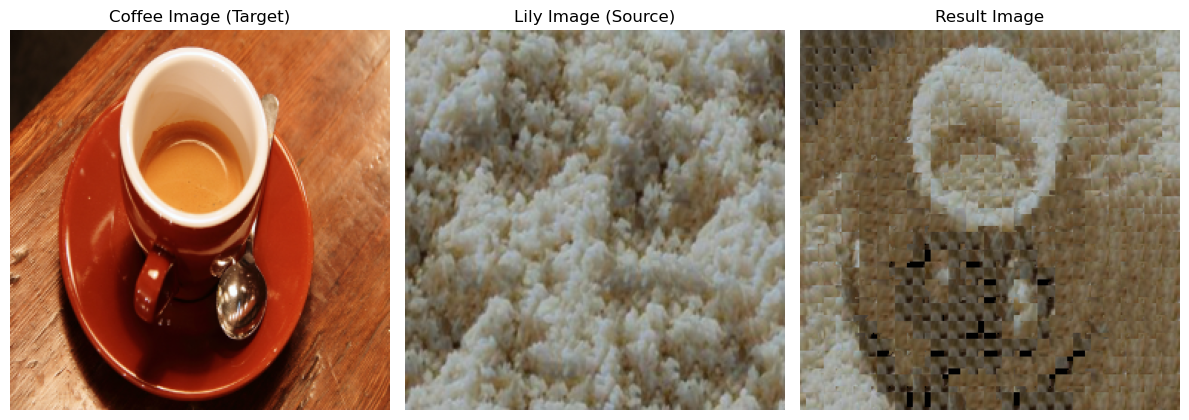

In [5]:

# Load images
coffee_image = img_as_float(data.coffee())

# Load texture image from file (assuming RGBA image)
texture_image = img_as_float(io.imread('rice_texture2.jpg'))

# Use only the RGB channels
texture_image = texture_image[..., :3]

# Resize images for demonstration
coffee_image = resize(coffee_image, (256, 256), anti_aliasing=True)
texture_image = resize(texture_image, (256, 256), anti_aliasing=True)

# Perform image segmentation using felzenszwalb algorithm
segments = segmentation.felzenszwalb(coffee_image, scale=100, sigma=0.5, min_size=50)

# Define patch size and overlap
patch_size = 16
overlap = 4

# Perform texture transfer with image segmentation
result_image = texture_transfer(coffee_image, texture_image, segments, patch_size, overlap)

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Coffee Image (Target)')
plt.imshow(coffee_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Lily Image (Source)')
plt.imshow(texture_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Result Image')
plt.imshow(result_image)
plt.axis('off')

plt.tight_layout()
plt.show()


## Efros and Leung Algorithm - superpixel
An attempt to get rid of stitching artifacts. We can divided target image into superpixels, each pixels perserve features of original image and representing an area of similarity within.
Efros algorithm the fill in each pixel with patch from texture image.
![Title](textureSLIC.png)

## Other Superpixel approach
![Title](RiceSLIC.png)
![Title](IceSLIC.png)
![Title](FireSLIC.png)

In [6]:
def texture_transfer_using_superpixels(target_image, sample_image, segments, patch_size):
    result_image = np.zeros_like(target_image)

    sample_patches = extract_patches(sample_image, patch_size, step=1)

    for segment_val in np.unique(segments):
        segment_mask = segments == segment_val
        segment_coords = np.argwhere(segment_mask)

        for coord in segment_coords:
            i, j = coord
            if i + patch_size <= target_image.shape[0] and j + patch_size <= target_image.shape[1]:
                target_patch = target_image[i:i+patch_size, j:j+patch_size]
                best_patch = find_best_patch(sample_patches, target_patch)
                result_image[i:i+patch_size, j:j+patch_size] = best_patch

    return result_image

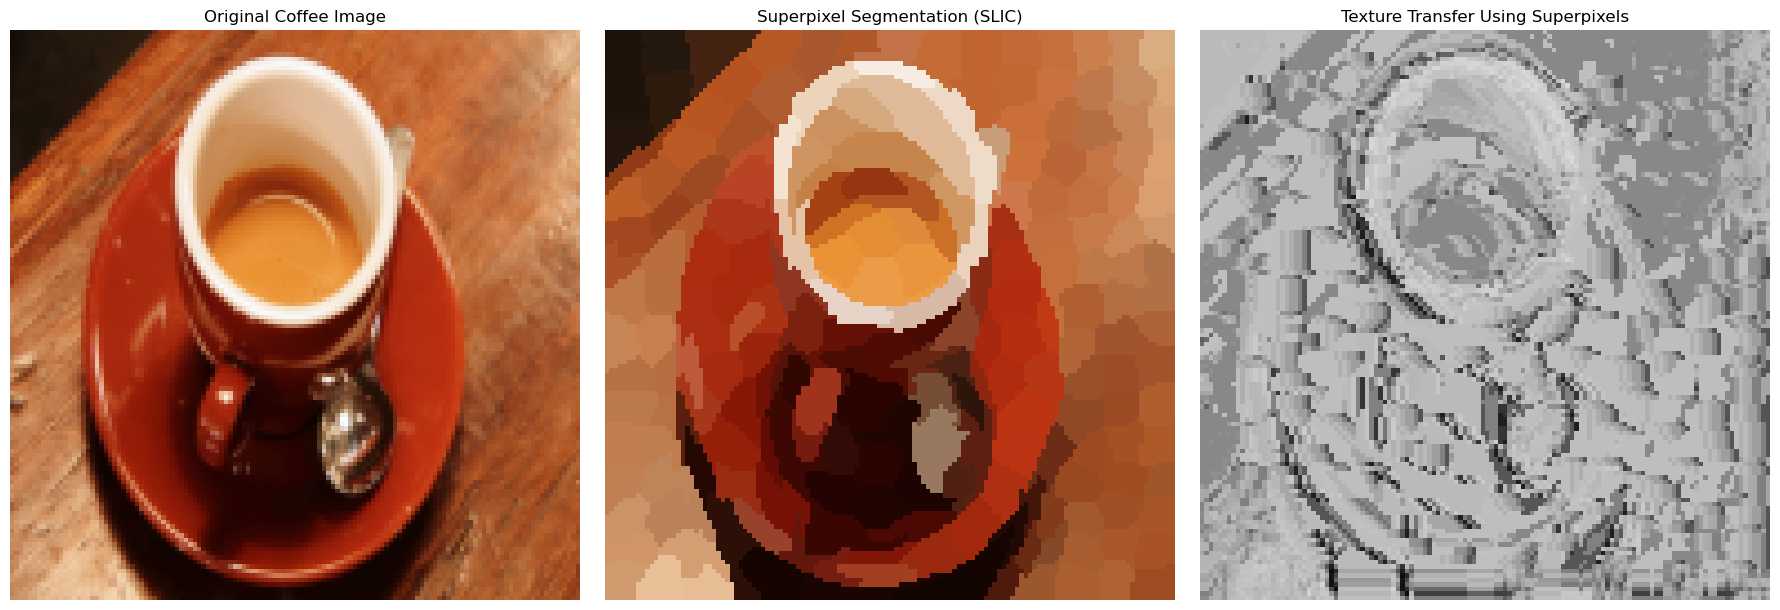

In [7]:


# Load image
coffee_image = img_as_float(data.coffee())

# Load texture image from file
texture_image = img_as_float(io.imread('texture1.jpeg'))

# Use only the RGB channels
texture_image = texture_image[..., :3]

# Resize images for demonstration
coffee_image = resize(coffee_image, (128, 128), anti_aliasing=True)
texture_image = resize(texture_image, (128, 128), anti_aliasing=True)

# Perform superpixel segmentation using SLIC
num_superpixels = 256  # Increase the number of superpixels for finer segments
segments = segmentation.slic(coffee_image, n_segments=num_superpixels, compactness=10, sigma=1, start_label=1)

# Define patch size and overlap
patch_size = 8

# Perform texture transfer using superpixels
result_image = texture_transfer_using_superpixels(coffee_image, texture_image, segments, patch_size)

# Display the images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
ax[0].imshow(coffee_image)
ax[0].set_title('Original Coffee Image')
ax[0].axis('off')

# Superpixel Segmentation Result
ax[1].imshow(color.label2rgb(segments, coffee_image, kind='avg'))
ax[1].set_title('Superpixel Segmentation (SLIC)')
ax[1].axis('off')

# Texture Transfer Result
ax[2].imshow(result_image)
ax[2].set_title('Texture Transfer Using Superpixels')
ax[2].axis('off')

plt.tight_layout()
plt.show()


## Fast Neural Network
Fast Neural Network is a style transfer Convolutional Neural network. Here used pre-trained model from ONNX Model Zoo.
![](FNNCandy.png)![](FNNmosic.png)


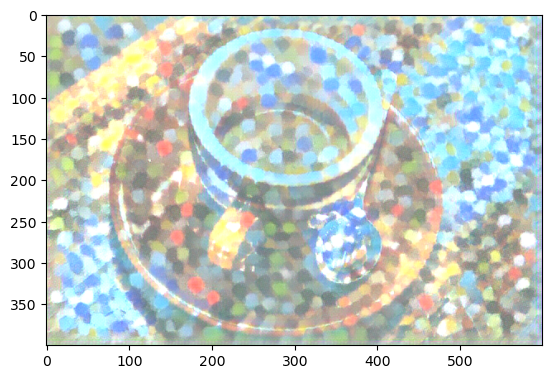

In [8]:
import cv2
import numpy as np

output_image_path = 'FNNtransfer.jpg'
model_path = 'pointilism-9.onnx'

input_image = data.coffee()
input_height, input_width = input_image.shape[:2]

net = cv2.dnn.readNetFromONNX(model_path)
blob = cv2.dnn.blobFromImage(input_image, 1.0, (input_width, input_height),
                             (103.939, 116.779, 123.680), swapRB=False, crop=False)

net.setInput(blob)
output = net.forward()
output = output.squeeze().transpose((1, 2, 0))

output += np.array((103.939, 116.779, 123.680))
output = np.clip(output, 0, 255).astype('uint8')

plt.imshow(output)
plt.show()


## Transfered Image on 3D (?)
Original RGB image and Depth map:
<p align="center">
  <img alt="..." src="RGBimg_resized.jpg">
  <img alt="..." src="Depthimg_resized.jpg">
</p>

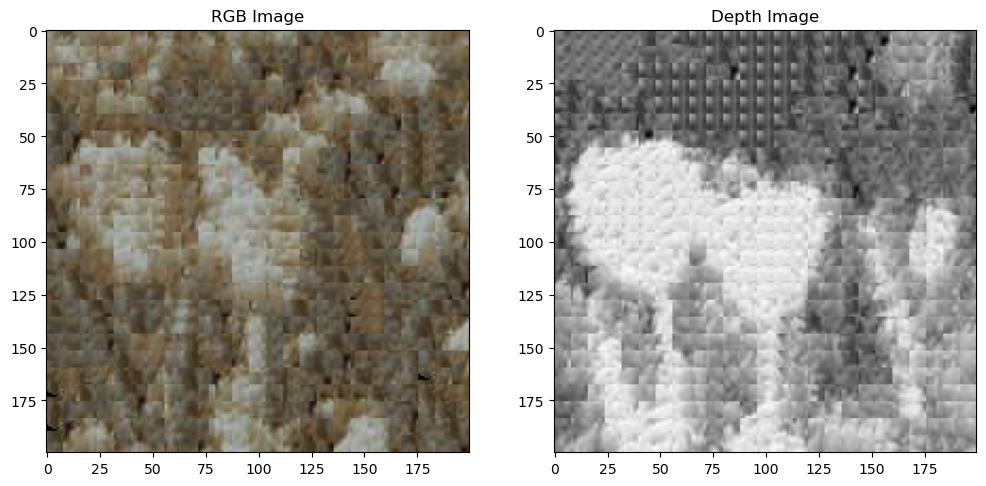

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
# Load the RGB and depth images
#rgb_image_path = "RGBimg_resized.jpg"
#depth_image_path = "Depthimg_resized.jpg"
rgb_image_path = "texture_transfer_flower.jpg"
depth_image_path = "texture_transfer_depth_gray.jpg"


rgb_image = cv2.imread(rgb_image_path)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_GRAYSCALE)

# Display the RGB and Depth images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("RGB Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Depth Image")
plt.imshow(depth_image, cmap='gray')

plt.show()


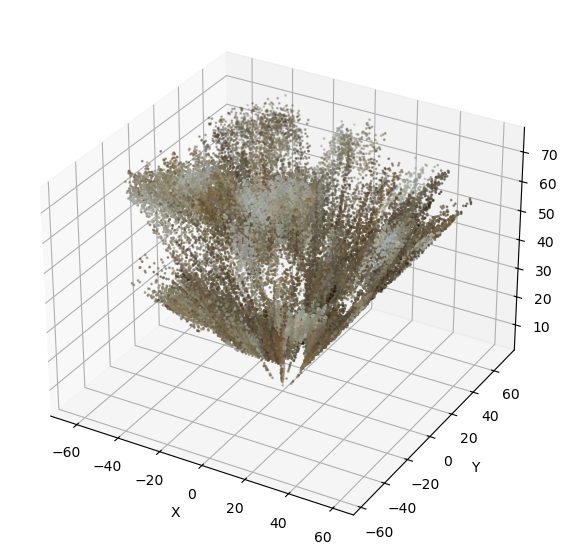

DONE


In [10]:


depth_resized = cv2.resize(depth_image, (rgb_image.shape[1], rgb_image.shape[0]))
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
# Assume a maximum depth value for normalization
max_depth_value = 100.0  # Example maximum depth value

# Invert depth values if needed
depth_normalized = depth_resized / 255.0 * max_depth_value

# Get the height and width of the resized depth image
h, w = depth_normalized.shape

# Create a mesh grid for pixel coordinates
x, y = np.meshgrid(np.arange(w), np.arange(h))

# Flatten the resized depth image, x, and y


depth_flat = depth_normalized.flatten()
x_flat = x.flatten()
y_flat = y.flatten()

# Generate 3D coordinates
z = depth_flat
x = (x_flat - w / 2) * z / max_depth_value
y = (y_flat - h / 2) * z / max_depth_value

# Create the point cloud (x, y, z, color)
points = np.vstack((x, y, z)).transpose()
colors = rgb_image.reshape(-1, 3) /255.0 # Normalize the RGB values

# Combine points and colors
point_cloud = np.hstack((points, colors))

# Sample a subset of the point cloud for visualization to avoid overplotting
sampled_points = point_cloud[::1]  # Take every 100th point for visualization

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the sampled points
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c=sampled_points[:, 3:], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
print("DONE")


In [ ]:

depth_resized = cv2.resize(depth_image, (rgb_image.shape[1], rgb_image.shape[0]))
max_depth_value = 300.0

depth_normalized = depth_resized / 255.0 * max_depth_value

h, w = depth_normalized.shape

# Create Meshgrid
x, y = np.meshgrid(np.arange(w), np.arange(h))

depth_flat = depth_normalized.flatten()
x_flat = x.flatten()
y_flat = y.flatten()

# Find 3D points
z = depth_flat
x = (x_flat - w / 2) * z / max_depth_value
y = (y_flat - h / 2) * z / max_depth_value

print("DONE")
points = np.vstack((x, y, z)).transpose()
colors = rgb_image.reshape(-1, 3) / 255.0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])